In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix

import pickle

%matplotlib inline


## Load csv files

In [2]:

df_gol = pd.read_csv('uniprot-golgi-unreviewed.csv')
df_mito = pd.read_csv('uniprot-mito-reviewed2.csv')
df_pm = pd.read_csv('uniprot-pm-reviewed.csv')
df_cyto = pd.read_csv('uniprot-cytoplasm-20K.csv')
df_ER = pd.read_csv('uniprot-ER-136K.csv')
df_nuc = pd.read_csv('uniprot-nucleus-reviewed.csv')
df_lyso = pd.read_csv('uniprot-lysosome-unreviewed.csv')

In [3]:
df_gol2 = df_gol.sample(frac=0.33)
df_ER2 = df_ER.sample(frac=0.27)
df_nuc2 = df_nuc.sample(frac=0.5)
df_lyso2 = df_lyso.sample(frac=0.5)

In [4]:
proteins = pd.concat([df_mito,df_pm,df_cyto,df_gol2,df_ER2,df_nuc2,df_lyso2])
proteins.head()

,name,sequence,location,label
0,sp|Q9BV35|SCMC3_HUMAN,MRGSPGDAERRQRWGRLFEELDSNKDGRVDVHELRQGLARLGGGNP...,6,mitochondria
1,sp|Q6NUK1|SCMC1_HUMAN,MLRWLRDFVLPTAACQDAEQPTRYETLFQALDRNGDGVVDIGELQE...,6,mitochondria
2,sp|Q9NUT2|MITOS_HUMAN,MLVHLFRVGIRGGPFPGRLLPPLRFQTFSAVRNTWRNGKTGQLHKA...,6,mitochondria
3,sp|Q6KCM7|SCMC2_HUMAN,MLCLCLYVPVIGEAQTEFQYFESKGLPAELKSIFKLSVFIPSQEFS...,6,mitochondria
4,sp|P53230|TAM41_YEAST,MLRVSENGLRFLLKCHSTNVSMFNRLLSTQIKEGRSSIDDAGIIPD...,6,mitochondria


In [5]:
proteins.shape

(184289, 4)

In [6]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [7]:
proteins.location.value_counts()

0    33594
8    30734
7    26197
1    26015
6    24128
9    23119
3    20502
Name: location, dtype: int64

In [8]:
proteins.label.value_counts()

ER                 33594
lysosome           30734
nucleus            26197
Golgi              26015
mitochondria       24128
plasma_membrane    23119
cytoplasm          20502
Name: label, dtype: int64

In [9]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(176894, 4)

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [10]:
# In this case, tripeptide frequency is used for analysis
#vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(5,5))
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(6,6))

In [11]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(141515, 21550741) (141515,)
(35379, 21550741) (35379,)


In [13]:
y_test.value_counts()

0    6654
8    6081
1    5083
7    4768
9    4521
6    4419
3    3853
Name: location, dtype: int64

## Majority Vote Classifier

In [14]:
# three classifiers: SGD, PassiveAggressiveClassifier, MNB

clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB()

In [15]:
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))

Majority Voting Classifier Score: 0.87


In [16]:
# Generate Confusion Matrix 
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model

[[6135  159   25  112   79   10  134]
 [ 176 4748   22   59   34   13   31]
 [  19    1 3113  184  408   13  115]
 [  50   16  213 3514  383   29  214]
 [  46    6  320  396 3785   15  200]
 [  16   18   70   86   89 5712   90]
 [  52    6  187  237  354   28 3657]]


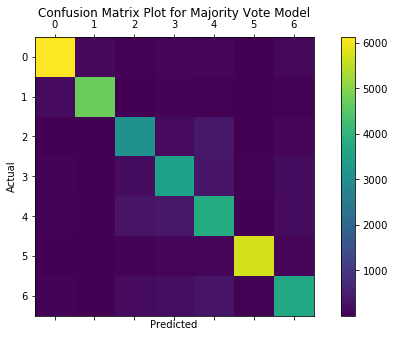

In [17]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Majority Vote Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()